info about dataset : https://ai.stanford.edu/~amaas/data/sentiment/

Please note this notebook should not be considered final as it still needs improvement and cleaning, I'm including it as an example of technologies used.

In [ ]:
from google.colab import files
import io
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB

there's a couple of package downloads for nltk that are necessary for our code to run

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
uploaded = files.upload()

Saving LargeMovieReviewDataset.csv to LargeMovieReviewDataset.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['LargeMovieReviewDataset.csv']))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


50000 columns all non null, looking good

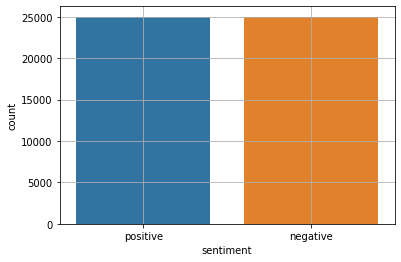

In [ ]:
sns.countplot(x=df['sentiment'])
plt.grid()

looks like the sentiment is equally split

In [ ]:
df['review'] = df['review'].astype('str')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


There are unicode characters, some html relics and different cases. We're gonna have to build a cleaning script

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df['review'] = df['review'].str.lower()

function that cleans html in a string

In [ ]:
def clean_html(html):
  soup = BeautifulSoup(html,"html.parser")

  for data in soup(['style', 'script' ,'code', 'a']):
      data.decompose()

  return ' '.join(soup.stripped_strings)

function that applies the previous function to an entire column

In [ ]:
def clean_html_column(df, column_name):

    df['cleaned'] = df[column_name].apply(lambda x: clean_html(x))
    return df

In [ ]:
clean_html_column(df, 'review')

,review,sentiment,cleaned
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is..."
...,...,...,...
49995,i thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,i am a catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,i'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...


Wordclouds! - Before we go any further let's take a look if we can visualise if one can see the sentiment on a visualisation such as wordclouds. 

In [ ]:
neg_phrases = df[df.sentiment == 'negative'].astype(str)
neg_words = []
for t in neg_phrases.cleaned:
  neg_words.append(t)
neg_text = pd.Series(neg_words).str.cat(sep=' ')

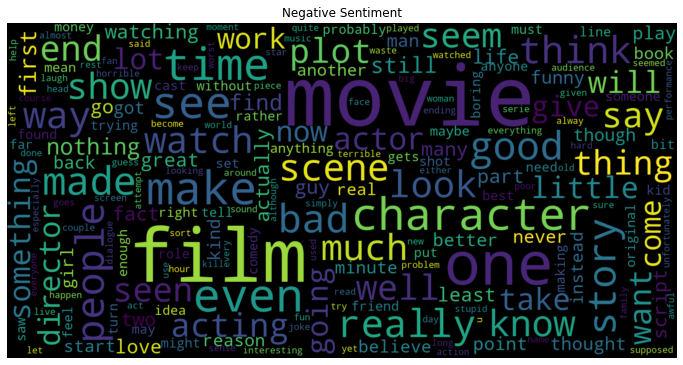

In [ ]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis("off")
plt.show()

In [ ]:
pos_phrases = df[df.sentiment == 'positive'].astype(str)
pos_words = []
for t in pos_phrases.cleaned:
  pos_words.append(t)
pos_text = pd.Series(pos_words).str.cat(sep=' ')

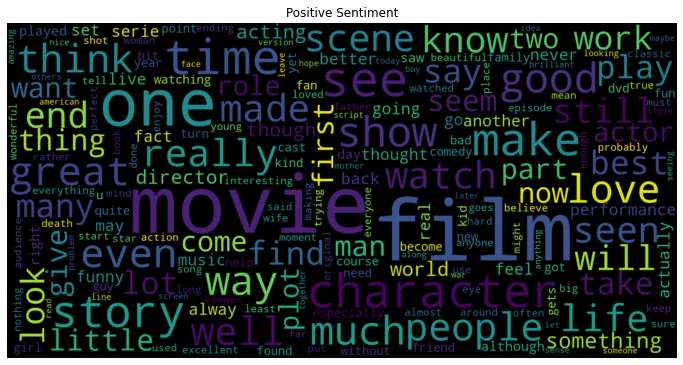

In [ ]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis("off")
plt.show()

A lot of words are neutral in both wordclouds such as movie, film, character, actor etc. Interstingly enough its not too easy to guess the sentiment on the negative reviews but it's easier to spot positive adjectives in the positive wordcloud

ok, all lowercase and html cleaning are a nice first step but we need to go deeper than this. Let's remove all characters that are ASCII characters.The pattern [^\x00-\x7F]+ matches one or more consecutive non-ASCII characters, we don't want these.

In [ ]:
def remove_unicode(string):
    return re.sub(r'[^\x00-\x7F]+','', string)

let's apply it to a column now

In [ ]:
def remove_unicode_from_column(df, column):
    df[column] = df[column].apply(remove_unicode)
    return df

In [ ]:
remove_unicode_from_column(df, 'cleaned')

,review,sentiment,cleaned
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is..."
...,...,...,...
49995,i thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,i am a catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,i'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...


Before I go onto stemming and lemmatization I'm going to tokenize the text first.

In [ ]:
def tokenize_string(text):
    tokens = word_tokenize(text)
    return tokens

There's several tokenize functions here. Initially i just used the first ones, then I saw that in some cases (especially in spacy_lemmatization) a lot of words that had significant influence on the model were iterations of the same words including multiple characters (think nooo ,noooooo etc) so i included a cleaning step to remove that. Initially by a loop but it just ran longer so i replaced that with another function

There was an issue with string repeats while looking at tf-idf scores so i've added a remove_repeats function while tokenizing columns

In [ ]:
def tokenize_column(df, column_name):
    def remove_repeats(token):
        return re.sub(r'(.)\1{2,}', r'\1\1', token)
    
    df['tokenized'] = df[column_name].apply(lambda x: [remove_repeats(t) for t in word_tokenize(x)])
    return df

In [ ]:
tokenize_column(df, 'cleaned')

,review,sentiment,cleaned,tokenized
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,"[basically, there, 's, a, family, where, a, li..."
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","[petter, mattei, 's, ``, love, in, the, time, ..."
...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[i, thought, this, movie, did, a, down, right,..."
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...","[bad, plot, ,, bad, dialogue, ,, bad, acting, ..."
49997,i am a catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[i, am, a, catholic, taught, in, parochial, el..."
49998,i'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...,"[i, 'm, going, to, have, to, disagree, with, t..."


Note to self - short tokens sich as 'a'  or ''s' remain. Add function to remove it

Ok, with the script below I'm trying to do several things. The most important is of course stemmling and lemmatizing the tokens. It's also removing unicode and lowercasing the letters in this step. We're also introducing stopwords here and removing tokens present in them. I initially forgot to include stopwords and having to rerun this huge if loop is a pain as it usually takes more than 30 minutes. Ideally it should be rewritten as something that consumes less RAM. It's a nightmare having to re-run it to check some changes

In [ ]:
nlp = spacy.load('en_core_web_sm')

def clean_string(tokens, stem='Stem'):
    stop_words = set(stopwords.words("english"))
    cleaned = [remove_unicode(token) for token in tokens]
    cleaned = [token.lower() for token in cleaned if token.isalpha()]
    cleaned = [token for token in cleaned if token not in stop_words]
    
    if stem == 'Stem':
        stemmed = [stemmer.stem(token) for token in cleaned]
        return stemmed
    elif stem == 'Lem':
        lemmatized = [wordnet.lemmatize(token) for token in cleaned]
        return lemmatized


In [ ]:
def clean_and_stem_column(df, column_name, tokenized=True):
    if not tokenized:
        df = tokenize_column(df, column_name)
        
    df['stemmed'] = df['tokenized'].apply(lambda x: clean_string(x, stem='Stem'))
    df['lemmatized'] = df['tokenized'].apply(lambda x: clean_string(x, stem='Lem'))

    return df

In [ ]:
stemmer = SnowballStemmer("english")
wordnet = WordNetLemmatizer()

In [ ]:
clean_and_stem_column(df, 'tokenized', tokenized=True)

,review,sentiment,cleaned,tokenized,stemmed,lemmatized
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, review, mention, watch, oz, episod, hook...","[one, reviewer, mentioned, watching, oz, episo..."
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil...","[wonder, littl, product, film, techniqu, fashi...","[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonderful, way, spend, time, hot, su..."
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,"[basically, there, 's, a, family, where, a, li...","[basic, famili, littl, boy, jake, think, zombi...","[basically, family, little, boy, jake, think, ..."
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","[petter, mattei, 's, ``, love, in, the, time, ...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visually, ..."
...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[i, thought, this, movie, did, a, down, right,...","[thought, movi, right, good, job, creativ, ori...","[thought, movie, right, good, job, creative, o..."
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...","[bad, plot, ,, bad, dialogue, ,, bad, acting, ...","[bad, plot, bad, dialogu, bad, act, idiot, dir...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,i am a catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[i, am, a, catholic, taught, in, parochial, el...","[cathol, taught, parochi, elementari, school, ...","[catholic, taught, parochial, elementary, scho..."
49998,i'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...,"[i, 'm, going, to, have, to, disagree, with, t...","[go, disagre, previous, comment, side, maltin,...","[going, disagree, previous, comment, side, mal..."


Comparison of word importance in stemming and lemmatization

#Stemming

In [ ]:
tfidf = TfidfVectorizer()

Join the lists of stemmed words into single strings

In [ ]:
df['stemmedTFIDF'] = df['stemmed'].apply(lambda x: ' '.join(x))

In [ ]:
tfidf_matrix = tfidf.fit_transform(df['stemmedTFIDF'])

In [ ]:
feature_names = tfidf.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tfidf_sum = tfidf_matrix.sum(axis=0)

In [ ]:
def plot_top_bottom_ngrams(model, n, feature_names):
    # get the feature importance for the model
    feature_importance = model.idf_
    # sort the feature importance values in descending order
    sorted_index = np.argsort(feature_importance)[::-1]
    # get the feature names corresponding to the sorted feature importance values
    sorted_feature_names = np.array(feature_names)[sorted_index]
    # get the sorted feature importance values
    sorted_feature_importance = feature_importance[sorted_index]
    # get the top n feature names and their importance values
    top_n = sorted_feature_names[:n], sorted_feature_importance[:n]
    # get the bottom n feature names and their importance values
    bottom_n = sorted_feature_names[-n:], sorted_feature_importance[-n:]
    # plot the top and bottom n n-grams
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(range(n), top_n[1], align='center')
    ax.set_yticks(range(n))
    ax.set_yticklabels(top_n[0])
    ax.invert_yaxis()
    ax.set_xlabel("TF-IDF Score")
    ax.set_title("Top {} N-grams by TF-IDF Score".format(n))
    plt.show()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(range(n), bottom_n[1], align='center')
    ax.set_yticks(range(n))
    ax.set_yticklabels(bottom_n[0])
    ax.invert_yaxis()
    ax.set_xlabel("TF-IDF Score")
    ax.set_title("Bottom {} N-grams by TF-IDF Score".format(n))
    plt.show()

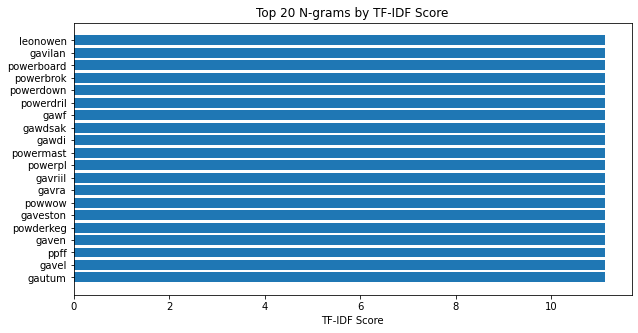

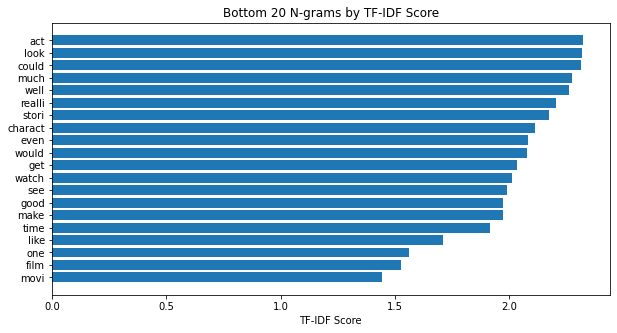

In [ ]:
plot_top_bottom_ngrams(tfidf, 20, feature_names)

#lemmatization

In [ ]:
df['lemmatizedTFIDF'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
tfidf_matrix = tfidf.fit_transform(df['lemmatizedTFIDF'])

In [ ]:
feature_names = tfidf.get_feature_names()

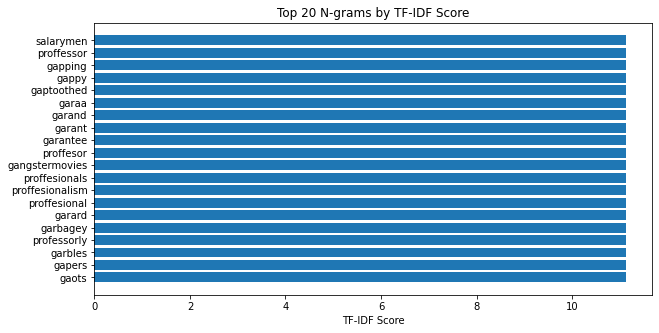

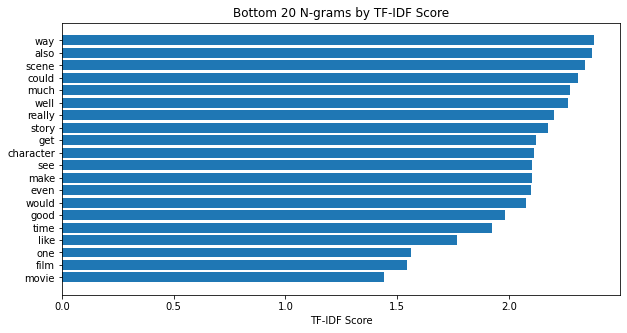

In [ ]:
plot_top_bottom_ngrams(tfidf, 20, feature_names)

# Models comparison


From here I'll be using lemmatized comments to build our models. If time allows i might check out how they perform on stemmed for comparison

In [ ]:
df_tosplit = df[['sentiment', 'lemmatizedTFIDF']].copy()

encoding sentiment values

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df_tosplit.sentiment.values)

Splitting train/test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tosplit.lemmatizedTFIDF.values, y, test_size=0.2, shuffle=True, stratify=y)

Setting up TF-IDF to both training and test sets, this time paying more attention to parameters

In [ ]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xtest_tfv = tfv.transform(X_test)

Here we define multiclass version of logarythmic loss metric to evaluate the models

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """ :param actual: Array containing the actual target classes
        :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

Let's kick it off with Naive Bayes

In [ ]:
clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

y_pred = clf.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss: 0.290 
Accuracy: 0.878
Precision: 0.878029274587024
Recall: 0.878
F1-Score: 0.8779976380342723

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5000
           1       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Not too shabby actually! Reminder, the smaller logloss the better the fit of the classification. 

In [ ]:
y_scores = predictions[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve for Naive Bayes', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [ ]:
clf = LogisticRegression(C=8.0)
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xtest_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

y_pred = clf.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss: 0.248 
Accuracy: 0.9044
Precision: 0.9045429816714419
Recall: 0.9044
F1-Score: 0.904391552037538

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
y_scores = predictions[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve for Logistic Regression', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

Interesting. A typical Logistic Regression performed better than Naive Bayes without tuning hyperparameters. The difference is much more significant after we adjust alpha for multinomial NB and C for LogReg across pretty much all parameters LogReg does a better job, whether we take into account area under ROC curve, logloss or numerical scores

In [ ]:
sgd = SGDClassifier(alpha=0.0001)
sgd.fit(xtrain_tfv, y_train)

y_pred = sgd.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8901
Precision: 0.8908915553996843
Recall: 0.8901
F1-Score: 0.8900443349445657

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.87      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



SGD did worst so far. tuning parameters did not improve the model much as it seems to perform best around default value

SVM sounds like a nightmare computation-wise. I'm going to apply SVD to reduce number of components to 120 to be able to actually run SVM in less than a century. Then I scale the data obtained from SVD and rename variable to reuse without scaling.

In [ ]:
svd = TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xtest_tfv)


scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
clf = SVC(C=0.2, probability=True)
clf.fit(xtrain_svd_scl, y_train)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))



logloss: 0.302 


In [ ]:
y_pred = clf.predict(xvalid_svd_scl)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.874
Precision: 0.8742851154295295
Recall: 0.874
F1-Score: 0.8739759999894381

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.89      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Even with limited number of components support vector machines has obtained better logloss than the other methods with logloss = 0.302 at C=1

Looking forward to trying deep learning and boost methods. This one was a real lesson in patience and paying attention to RAM as some of the functions and models took ages to run (looking at you SVM)

Please note - I'm running all the models below with stemmed data instead of lemmatized but it seems that the method of preprocessing the text has actually a very little influence on the models as long as the data is processed. Tuning hyperparameters seem to have much higher influence on the scores. Treat the rows below as a curiosity as some have different hyperparametrs just to check what would happen and some more conclusions.

Overall:

-Gradient Descent performs by far the worst
-LogRegression with tuned hyperparameters performs probably the best out of 'simple' methods
-Naive Bayes obtains quite good scores especially while tuned but not quite as good as LogReg
-Support Vector Machines is just so heavy. It performs well but at the expense of a huge amount of computation power and time. A better method of tuning its parameters such as cross validation seems to be needed before running the model but unforunately I won't have time to build it before the deadline so I'm submitting as is

# Model comparison again - this time with Stemmed data

In [ ]:
df_tosplit = df[['sentiment', 'stemmedTFIDF']].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tosplit.stemmedTFIDF.values, y, test_size=0.2, shuffle=True, stratify=y)

In [ ]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xtest_tfv = tfv.transform(X_test)

In [ ]:
clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

y_pred = clf.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss: 0.283 
Accuracy: 0.8812
Precision: 0.8813587062391885
Recall: 0.8812
F1-Score: 0.8811876387619368

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Ever so slightly worse on stemmed comments than on lemmatized using NB and no tuning. Decreasing the alpha increases the fit until a certain point

In [ ]:
y_scores = predictions[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve for Naive Bayes', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [ ]:
clf = LogisticRegression(C=7.0)
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xtest_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

y_pred = clf.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss: 0.250 
Accuracy: 0.8998
Precision: 0.8999935969009002
Recall: 0.8998
F1-Score: 0.8997878743327943

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
y_scores = predictions[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve for Logistic Regression', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

seems that the higher the C the lower the LogLoss in case of Logistic regression but above 7 it reaches max iterations. We could increase those but in this case i believe it's the case of diminishing return here.

In [ ]:
sgd = SGDClassifier(alpha = 0.1)
sgd.fit(xtrain_tfv, y_train)

y_pred = sgd.predict(xtest_tfv)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8952
Precision: 0.8960674828436233
Recall: 0.8952
F1-Score: 0.8951425842734446

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.88      0.92      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Slightly better with higher alpha, but still worst method by far

In [ ]:
svd = TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xtest_tfv)


scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
clf = SVC(C=2.0, probability=True)
clf.fit(xtrain_svd_scl, y_train)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

y_pred = clf.predict(xvalid_svd_scl)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss: 0.693 
Accuracy: 0.5003
Precision: 0.5003000538776743
Recall: 0.5003
F1-Score: 0.5002775674600033

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      5000
           1       0.50      0.49      0.50      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Overall it seems that checking the models on both stemmed and lemmatized data was not a useful exercise as the model perform pretty much the same on both. I'll leave it in the notebook just as a record for the work done. Rather than run everything twice it is wiser to spend time tuning hyperparameters. For this reason C parametr in SVC was set up as 3 here and couldnt converget for ages, then decreased to 2 in order to hopefully see difference between increasing and decreasing in pratice. Cross validation seems like a necessary step to tune parameters in SVC instead of manual tries but since it's about an hour to the deadline and the model is still running as I'm writing it I'm not going to implement it this time